In [1]:
from fastai.vision.all import *
from fastai.callback.wandb import WandbCallback
from sklearn.model_selection import StratifiedKFold

from ipyexperiments.ipyexperiments import IPyExperimentsPytorch
import timm,wandb

import IPython.display as disp
from timm.models import safe_model_name, set_fast_norm
from timm.models.layers import create_classifier, SelectAdaptivePool2d

In [2]:
%env WANDB_SILENT=true
warnings.filterwarnings('ignore')

env: WANDB_SILENT=true


In [3]:
VERSION  = "NB_EXP_004"
EXP_NAME = f"{VERSION}_convnext_tiny"

CSV_PATH     = Path('/data/train.csv')
DATA_PATH    = Path('/data/')
IMAGE_FOLDER = Path('/data/train/')
MODEL_FOLDER = Path(f'/runs/{VERSION}')

os.makedirs(MODEL_FOLDER, exist_ok=True)

LABELS = sorted(['broken', 'pure', 'discolored', 'silkcut'])
labels_class_map = {v:k for k,v in enumerate(LABELS)}
labels_class_map_rev = {v:k for k,v in labels_class_map.items()}

VIEWS = sorted(['top', 'bottom'])
views_class_map = {v:k for k,v in enumerate(VIEWS)}
views_class_map_rev = {v:k for k,v in views_class_map.items()}


TIMM_MODEL  = "convnext_tiny_in22ft1k"
GLOBAL_POOL = "concat"

NF = 5
BS = 32
SZ = 244
RE = True

In [4]:
all_df = pd.read_csv(CSV_PATH)
all_df.head()

,seed_id,view,image,label
0,0,top,train/00000.png,broken
1,1,bottom,train/00001.png,pure
2,3,top,train/00003.png,broken
3,4,top,train/00004.png,pure
4,5,top,train/00005.png,discolored


In [5]:
folds = all_df.copy()
fold_splits = []

Fold = StratifiedKFold(n_splits=NF, shuffle=True, random_state=42)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds["label"])):
    fold_splits.append(val_index)
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)

In [6]:
@Transform
def hflip(x: TensorTypes): return x.flip(3)

@Transform
def vflip(x: TensorTypes): return x.flip(2)

In [7]:
def get_dls(fold:int, size:int, bs:int, re:bool = False):
    
    item_tfms = [ToTensor, Resize(448, method=ResizeMethod.Squish)]
    aug_tfm = aug_transforms(flip_vert=True, 
                             size=size, 
                             max_rotate=360, 
                             max_zoom=1.3, 
                             max_lighting=0.1, 
                             p_lighting=0.25, 
                             pad_mode=PadMode.Zeros,
                             min_scale=0.75)
    batch_tfms = [IntToFloatTensor, *aug_tfm, Normalize.from_stats(*imagenet_stats)]
    if re: batch_tfms.append(RandomErasing())
    
    dblock = DataBlock(
        blocks     = (ImageBlock, CategoryBlock(vocab=LABELS)),
        splitter   = IndexSplitter(fold_splits[fold]),
        get_x      = ColReader('image', pref=DATA_PATH),
        get_y      = [ColReader('label')],
        item_tfms  = item_tfms,
        batch_tfms = batch_tfms )
    
    dls = dblock.dataloaders(folds, bs=bs)
    return dls

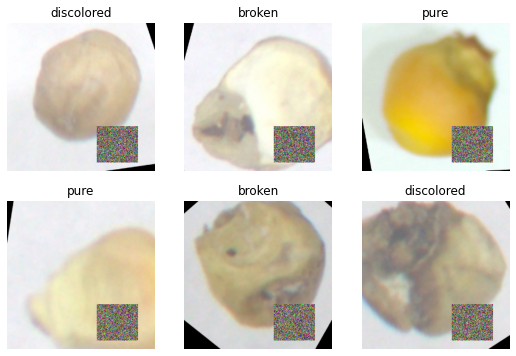

In [8]:
dls = get_dls(0, size=SZ, bs=BS, re=RE)
dls.show_batch(max_n=6)

In [9]:
from timm.models.helpers import group_modules, group_parameters

def timm_get_module_names(m):
    modules_names = group_modules(m, m.group_matcher(coarse=True))
    return L(modules_names.values())[:-1] #cut timm head

def timm_get_param_names(m):
    param_names = group_parameters(m, m.group_matcher(coarse=True))
    return L(param_names.values())[:-1] #cut timm head

def timm_body_params(timm_model, cut=-1):
    param_names = timm_get_param_names(timm_model)
    return L(param_names[:cut].concat(), param_names[cut:].concat())

def timm_split(m, cut=-1):
    "Splitter function for timm models"
    timm_model, head = m[0].model, m[1]
    body_groups = [g.map(timm_model.get_parameter) for g in timm_body_params(timm_model, cut)]
    return body_groups + [params(head)]


*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



SuggestedLRs(valley=0.001737800776027143, slide=0.0020892962347716093)
CPU: 610/54/3532 MB | GPU: 370/1228/6509 MB | Time 0:00:09.632 | (Consumed/Peaked/Used Total)


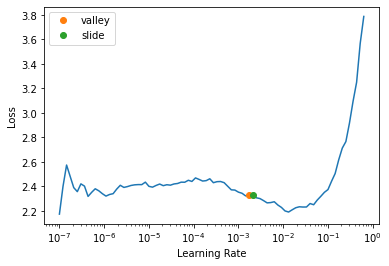

In [16]:
set_seed(42);set_fast_norm()

with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
    
    dls = get_dls(0, size=SZ, bs=BS, re=RE)
    
    learn = vision_learner(dls, TIMM_MODEL, n_out=dls.c, pretrained=True,
                loss_func=CrossEntropyLossFlat(), metrics=[accuracy], splitter=timm_split).to_fp16()
    
    print(learn.lr_find(suggest_funcs=(valley, slide)))

In [11]:
n_epo = 10; base_lr = 5e-03; 
SUFFIX = f"{SZ}_bs{BS}_epo{n_epo}_ft"
set_seed(42); set_fast_norm()

In [20]:
for fold_idx in range(5):
    with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
        
        with wandb.init(project='pog3_corn',
                        group=EXP_NAME, save_code=True,
                        name=f'{EXP_NAME}_{SUFFIX}_CV_{fold_idx:02d}'):
        
            dls = get_dls(fold_idx, size=SZ, bs=BS, re=RE)

            learn = vision_learner(dls, TIMM_MODEL, n_out=dls.c, pretrained=True,
                                   loss_func=CrossEntropyLossFlat(), metrics=[accuracy], 
                                   splitter=timm_split).to_fp16()

            cbs = [SaveModelCallback(monitor="accuracy", comp=np.greater),WandbCallback(log_preds=None)]
            learn.fine_tune(n_epo, base_lr, cbs=cbs)

            learn = learn.load("model")
            learn = learn.to_fp32()

            dirpath = MODEL_FOLDER/f'{EXP_NAME}_{SUFFIX}_CV_{fold_idx:02d}'
            learn.save(dirpath, with_opt=False)


*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



epoch,train_loss,valid_loss,accuracy,time
0,1.025748,0.844171,0.673298,00:34


Better model found at epoch 0 with accuracy value: 0.6732984185218811.


epoch,train_loss,valid_loss,accuracy,time
0,0.758240,0.668098,0.738220,00:44
1,0.694561,0.620613,0.753578,00:44
2,0.698939,0.583245,0.763002,00:44
3,0.659958,0.535647,0.786038,00:45
4,0.628280,0.558570,0.770681,00:44
5,0.580117,0.525480,0.793717,00:44
6,0.508224,0.497801,0.799651,00:44
7,0.468774,0.503476,0.800000,00:44
8,0.437549,0.495491,0.802443,00:44
9,0.454537,0.492012,0.797208,00:44


Better model found at epoch 0 with accuracy value: 0.7382199168205261.
Better model found at epoch 1 with accuracy value: 0.7535776495933533.
Better model found at epoch 2 with accuracy value: 0.7630017399787903.
Better model found at epoch 3 with accuracy value: 0.7860383987426758.
Better model found at epoch 5 with accuracy value: 0.7937172651290894.
Better model found at epoch 6 with accuracy value: 0.7996509671211243.
Better model found at epoch 7 with accuracy value: 0.800000011920929.
Better model found at epoch 8 with accuracy value: 0.802443265914917.
CPU: 332/45/3866 MB | GPU: 554/2112/7063 MB | Time 0:08:18.945 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



epoch,train_loss,valid_loss,accuracy,time
0,1.064449,0.962081,0.627225,00:34


Better model found at epoch 0 with accuracy value: 0.6272251605987549.


epoch,train_loss,valid_loss,accuracy,time
0,0.757763,0.649767,0.729145,00:44
1,0.690831,0.602689,0.768586,00:44
2,0.720933,0.607747,0.742059,00:45
3,0.621644,0.571226,0.764747,00:45
4,0.637440,0.541211,0.783944,00:44
5,0.574024,0.513901,0.791274,00:45
6,0.563739,0.495620,0.799302,00:45
7,0.493941,0.485742,0.803490,00:45
8,0.459829,0.475166,0.806981,00:45
9,0.478922,0.477864,0.805585,00:45


Better model found at epoch 0 with accuracy value: 0.7291448712348938.
Better model found at epoch 1 with accuracy value: 0.7685863971710205.
Better model found at epoch 4 with accuracy value: 0.7839441299438477.
Better model found at epoch 5 with accuracy value: 0.7912740111351013.
Better model found at epoch 6 with accuracy value: 0.7993019223213196.
Better model found at epoch 7 with accuracy value: 0.803490400314331.
Better model found at epoch 8 with accuracy value: 0.8069807887077332.
CPU: 0/47/3867 MB | GPU: 150/2328/7213 MB | Time 0:08:22.571 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



epoch,train_loss,valid_loss,accuracy,time
0,1.039456,0.819374,0.675628,00:34


Better model found at epoch 0 with accuracy value: 0.6756284832954407.


epoch,train_loss,valid_loss,accuracy,time
0,0.746645,0.660242,0.736732,00:44
1,0.725538,0.616752,0.753492,00:44
2,0.679191,0.671170,0.747556,00:45
3,0.638073,0.574646,0.770950,00:45
4,0.609707,0.606024,0.754539,00:45
5,0.561367,0.523738,0.790154,00:45
6,0.505907,0.551404,0.788757,00:45
7,0.494147,0.508240,0.796788,00:45
8,0.458418,0.502503,0.797486,00:45
9,0.459789,0.509379,0.799930,00:45


Better model found at epoch 0 with accuracy value: 0.7367318272590637.
Better model found at epoch 1 with accuracy value: 0.7534916400909424.
Better model found at epoch 3 with accuracy value: 0.7709497213363647.
Better model found at epoch 5 with accuracy value: 0.7901536226272583.
Better model found at epoch 7 with accuracy value: 0.7967877388000488.
Better model found at epoch 8 with accuracy value: 0.7974860072135925.
Better model found at epoch 9 with accuracy value: 0.7999301552772522.
CPU: 31/49/3898 MB | GPU: 56/2270/7269 MB | Time 0:08:20.833 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



epoch,train_loss,valid_loss,accuracy,time
0,1.065573,0.838043,0.663757,00:34


Better model found at epoch 0 with accuracy value: 0.6637569665908813.


epoch,train_loss,valid_loss,accuracy,time
0,0.767281,0.625984,0.743017,00:45
1,0.735008,0.626167,0.751397,00:45
2,0.682306,0.545621,0.775140,00:45
3,0.657690,0.528713,0.791899,00:45
4,0.631152,0.543065,0.790154,00:45
5,0.592861,0.504532,0.797835,00:45
6,0.529619,0.483731,0.809358,00:45
7,0.507933,0.466082,0.815642,00:45
8,0.446297,0.460685,0.817388,00:45
9,0.466726,0.458857,0.813897,00:45


Better model found at epoch 0 with accuracy value: 0.74301677942276.
Better model found at epoch 1 with accuracy value: 0.751396656036377.
Better model found at epoch 2 with accuracy value: 0.7751396894454956.
Better model found at epoch 3 with accuracy value: 0.7918994426727295.
Better model found at epoch 5 with accuracy value: 0.7978351712226868.
Better model found at epoch 6 with accuracy value: 0.8093575239181519.
Better model found at epoch 7 with accuracy value: 0.8156424760818481.
Better model found at epoch 8 with accuracy value: 0.8173882961273193.
CPU: 7/47/3905 MB | GPU: 254/2034/7523 MB | Time 0:08:21.699 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



epoch,train_loss,valid_loss,accuracy,time
0,1.061808,0.992482,0.638268,00:34


Better model found at epoch 0 with accuracy value: 0.6382681727409363.


epoch,train_loss,valid_loss,accuracy,time
0,0.790148,0.636758,0.744763,00:45
1,0.705335,0.595290,0.759427,00:44
2,0.688802,0.665556,0.740573,00:45
3,0.630181,0.573840,0.776187,00:45
4,0.614727,0.513084,0.791550,00:45
5,0.578911,0.549018,0.774441,00:45
6,0.540006,0.502884,0.798533,00:45
7,0.512296,0.496546,0.798184,00:45
8,0.465485,0.463994,0.817039,00:45
9,0.465110,0.466554,0.810754,00:45


Better model found at epoch 0 with accuracy value: 0.7447625994682312.
Better model found at epoch 1 with accuracy value: 0.7594273686408997.
Better model found at epoch 3 with accuracy value: 0.7761871218681335.
Better model found at epoch 4 with accuracy value: 0.7915502786636353.
Better model found at epoch 6 with accuracy value: 0.7985334992408752.
Better model found at epoch 8 with accuracy value: 0.8170391321182251.
CPU: 0/49/3906 MB | GPU: -8/2024/7515 MB | Time 0:08:24.220 | (Consumed/Peaked/Used Total)


In [12]:
pattern = f'{EXP_NAME}_{SUFFIX}_CV_' + '{fold:02d}'
folds_val_score = []

with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
    
    for fold_index in range(5):
        dls = get_dls(fold_index, size=SZ, bs=BS, re=RE)

        learn = vision_learner(dls, TIMM_MODEL, n_out=dls.c, pretrained=True,
                               loss_func=CrossEntropyLossFlat(), metrics=[accuracy], 
                               splitter=timm_split, model_dir=MODEL_FOLDER).to_fp16()
        
        checkpoint = pattern.format(fold=fold_index)
        print(f"Load from : {checkpoint!r} ({fold_index:02d})")
        
        learn.load(checkpoint)
        
        # original dl with validation tfms
        tst_dl = dls.valid.new()
        with tst_dl.dataset.set_split_idx(1), learn.no_mbar():
            preds0, targs = learn.get_preds(dl=tst_dl)
        
        # dl with hflip
        tst_dl_1 = dls.valid.new()
        tst_dl_1.after_batch.add(hflip)
        with tst_dl_1.dataset.set_split_idx(1), learn.no_mbar():
            preds1, _ = learn.get_preds(dl=tst_dl_1)
        
        # dl with vflip tfms
        tst_dl_2 = dls.valid.new()
        tst_dl_2.after_batch.add(vflip)
        with tst_dl_2.dataset.set_split_idx(1), learn.no_mbar():
            preds2, _ = learn.get_preds(dl=tst_dl_2)
        
        preds = (preds0+preds1+preds2)/3
        acc = accuracy(preds, targs).item()
        
        folds_val_score.append(acc)

disp.clear_output()    
print("============ Run summary (hflip+vflip TTA) ============")
print("folds score: ", [np.round(s, 5) for s in folds_val_score])
print("Avg: {:.5f}".format(np.mean(folds_val_score)))
print("Std: {:.5f}".format(np.std(folds_val_score)))

============ Run summary (hflip+vflip TTA) ============
folds score:  [0.81047, 0.81117, 0.80412, 0.81913, 0.81878]
Avg: 0.81274
Std: 0.00565
